# Unit load
In this notebook I show how the recall success for overload depends on different parameters

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '1e99cfe7b1982691a0212334a93d58057df83d56'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

#### Load libraries

In [3]:
from network import BCPNN, NetworkManager, BCPNNFast, Protocol
from data_transformer import build_ortogonal_patterns

from plotting_functions import plot_winning_pattern, plot_sequence
from analysis_functions import calculate_recall_success, calculate_timings

## Dependence on the overlap (o parameter)

In [4]:
# Patterns parameters
hypercolumns = 4
minicolumns = 70

# Manager properties
dt = 0.001
T_recall = 4.0
values_to_save = ['o']

compression_list = []

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns)
nn.k_inner = False

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Sequence protocol
overload_range = np.arange(2, 5, 1)
number_of_sequences = 3
half_width = 2

In [5]:
success_array = np.zeros((number_of_sequences , overload_range.size))
n = 3

for overload_index, overload in enumerate(overload_range):
    print(overload_index)
    units_to_overload = [j for j in range(overload)]

    chain_protocol = Protocol()
    chain = chain_protocol.create_overload_chain(number_of_sequences, half_width, units_to_overload)
    chain_protocol.cross_protocol(chain, training_time=training_time, inter_sequence_interval=inter_sequence_interval,
                              epochs=epochs)

    # Free patterns protocol
    free_patterns_protocol = Protocol()
    free_patterns_indexes = [i for i in range(chain[-1][-1] + 1, minicolumns)]
    free_patterns_protocol.simple_protocol(patterns_indexes=free_patterns_indexes, training_time=training_time,
                                           inter_sequence_interval=1.0, inter_pulse_interval=1.0, epochs=3)

    # Run protocols
    manager.run_network_protocol(free_patterns_protocol, verbose=False, empty_history=False)
    manager.run_network_protocol(chain_protocol, verbose=False, empty_history=False)


    for sequence_index, sequence in enumerate(chain):
        success = calculate_recall_success(manager, T_recall=T_recall, T_cue=0.100, I_cue=sequence[0],
                                           n=n, patterns_indexes=sequence)
        success_array[sequence_index, overload_index] = success

../analysis_functions.py:43: RuntimeWarning: invalid value encountered in double_scalars
  dis = [a / b for (a, b) in zip(nominator, denominator)]


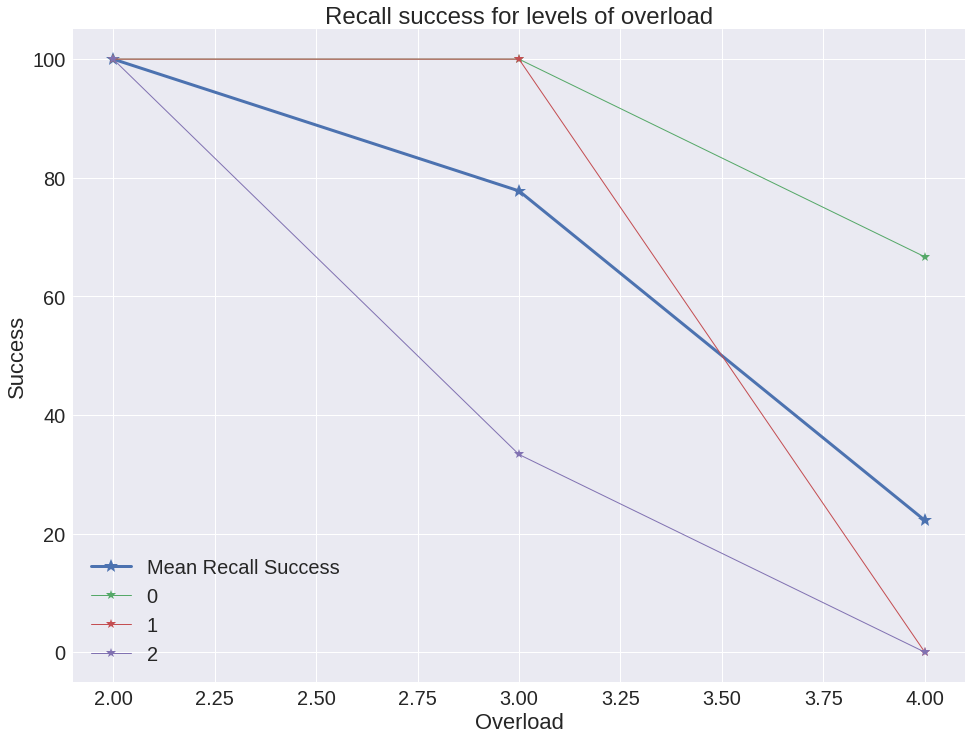

In [6]:
sns.set(font_scale=2.0)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(overload_range, np.mean(success_array, axis=0), '*-', markersize=14, linewidth=3, label='Mean Recall Success')

for sequence_index in range(len(chain)):
    ax.plot(overload_range, success_array[sequence_index, :], '*-', markersize=10, linewidth=1, label=str(sequence_index))

ax.legend()
ax.set_ylim([-5, 105])
ax.set_xlabel('Overload')
ax.set_ylabel('Success')
ax.set_title('Recall success for levels of overload')

## Dependence on sequence size

In [12]:
# Patterns parameters
hypercolumns = 4
minicolumns = 100

# Manager properties
dt = 0.001
T_recall = 4.0
values_to_save = ['o']

compression_list = []

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns)
nn.k_inner = False

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Sequence protocol
half_width_range = np.arange(2, 8, 2)
number_of_sequences = 3
units_to_overload = [0, 1]

In [13]:
success_array = np.zeros((number_of_sequences , half_width_range.size))
n = 3

for half_width_index, half_width in enumerate(half_width_range):

    chain_protocol = Protocol()
    chain = chain_protocol.create_overload_chain(number_of_sequences, half_width, units_to_overload)
    chain_protocol.cross_protocol(chain, training_time=training_time, inter_sequence_interval=inter_sequence_interval,
                              epochs=epochs)

    # Free patterns protocol
    free_patterns_protocol = Protocol()
    free_patterns_indexes = [i for i in range(chain[-1][-1] + 1, minicolumns)]
    free_patterns_protocol.simple_protocol(patterns_indexes=free_patterns_indexes, training_time=training_time,
                                           inter_sequence_interval=1.0, inter_pulse_interval=1.0, epochs=3)

    # Run protocols
    manager.run_network_protocol(free_patterns_protocol, verbose=False, empty_history=False)
    manager.run_network_protocol(chain_protocol, verbose=False, empty_history=False)


    for sequence_index, sequence in enumerate(chain):
        success = calculate_recall_success(manager, T_recall=T_recall, T_cue=0.100, I_cue=sequence[0],
                                           n=n, patterns_indexes=sequence)
        success_array[sequence_index, half_width_index] = success

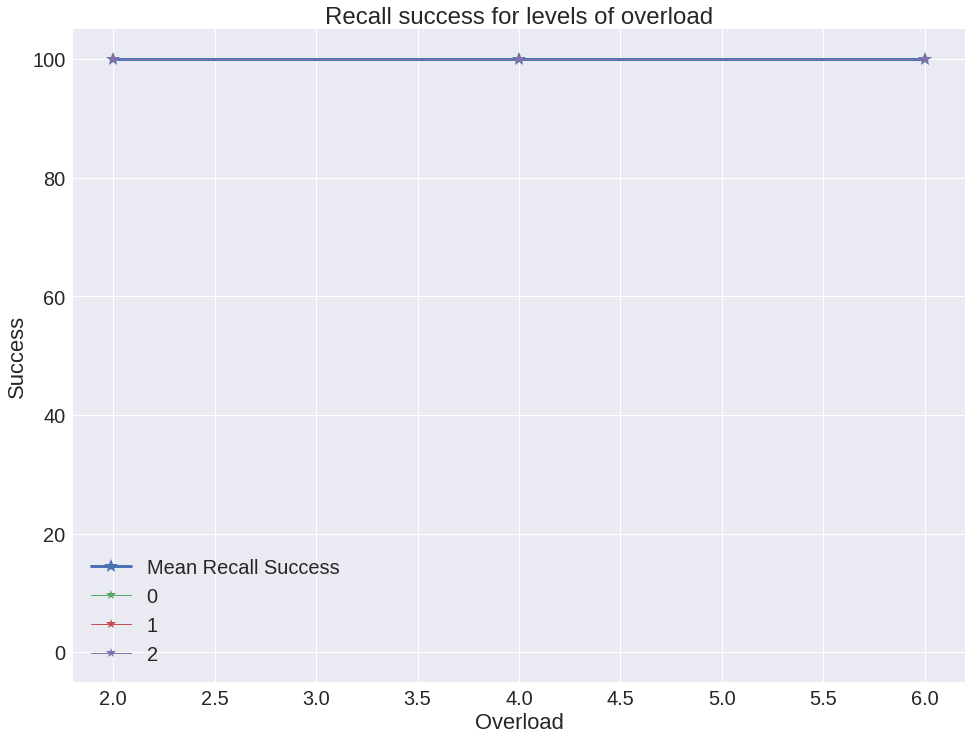

In [14]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(half_width_range, np.mean(success_array, axis=0), '*-', markersize=14, linewidth=3, label='Mean Recall Success')

for sequence_index in range(len(chain)):
    ax.plot(half_width_range, success_array[sequence_index, :], '*-', markersize=10, linewidth=1, label=str(sequence_index))

ax.legend()
ax.set_ylim([-5, 105])
ax.set_xlabel('Overload')
ax.set_ylabel('Success')
ax.set_title('Recall success for levels of overload')

## Number of sequences through a particular neuron (parameter p)

In [15]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50

# Manager properties
dt = 0.001
T_recall = 4.0
values_to_save = ['o']

compression_list = []

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns)
nn.k_inner = False

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Sequence protocol
half_width = 2
number_of_sequences_range = np.arange(2, 9, 1)
units_to_overload = [0, 1]

In [17]:
success_array = np.zeros((number_of_sequences_range[-1] , number_of_sequences_range.size))
n = 3

for number_of_sequences_range_index, number_of_sequences in enumerate(number_of_sequences_range):

    chain_protocol = Protocol()
    chain = chain_protocol.create_overload_chain(number_of_sequences, half_width, units_to_overload)
    chain_protocol.cross_protocol(chain, training_time=training_time, inter_sequence_interval=inter_sequence_interval,
                              epochs=epochs)

    # Free patterns protocol
    free_patterns_protocol = Protocol()
    free_patterns_indexes = [i for i in range(chain[-1][-1] + 1, minicolumns)]
    free_patterns_protocol.simple_protocol(patterns_indexes=free_patterns_indexes, training_time=training_time,
                                           inter_sequence_interval=1.0, inter_pulse_interval=1.0, epochs=3)

    # Run protocols
    manager.run_network_protocol(free_patterns_protocol, verbose=False, empty_history=False)
    manager.run_network_protocol(chain_protocol, verbose=False, empty_history=False)

    for sequence_index, sequence in enumerate(chain):
        success = calculate_recall_success(manager, T_recall=T_recall, T_cue=0.100, I_cue=sequence[0],
                                           n=n, patterns_indexes=sequence)
        success_array[sequence_index, number_of_sequences_range_index] = success

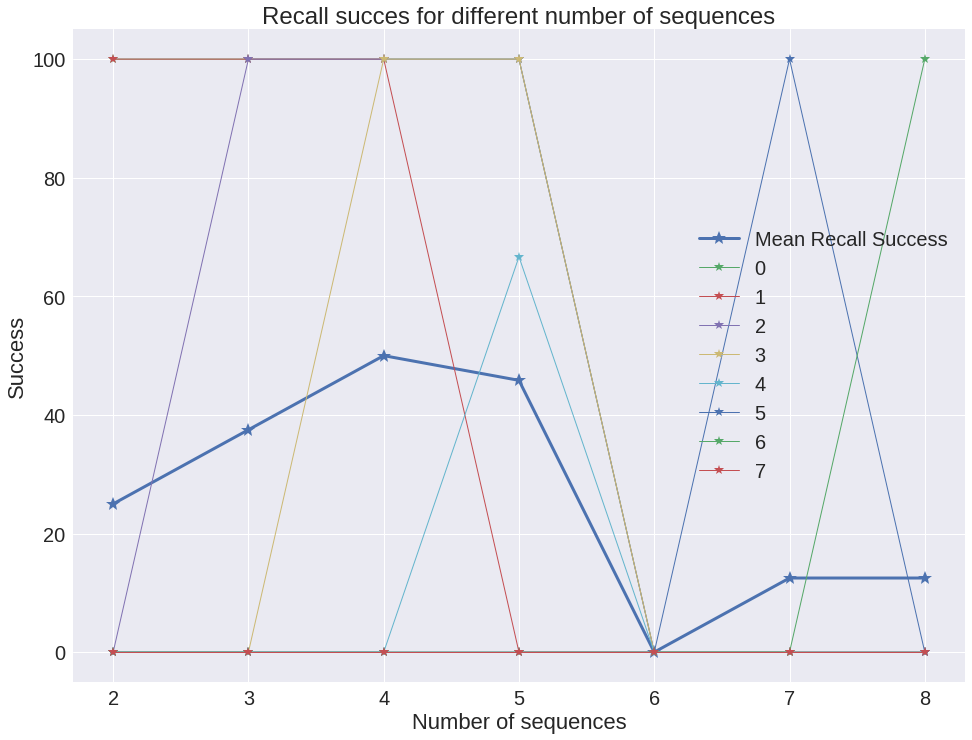

In [18]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(number_of_sequences_range, np.mean(success_array, axis=0), '*-', markersize=14, linewidth=3, label='Mean Recall Success')

for sequence_index in range(len(chain)):
    ax.plot(number_of_sequences_range, success_array[sequence_index, :], '*-', markersize=10, linewidth=1, label=str(sequence_index))

ax.legend()
ax.set_ylim([-5, 105])
ax.set_xlabel('Number of sequences')
ax.set_ylabel('Success')
ax.set_title('Recall succes for different number of sequences')